<a href="https://colab.research.google.com/github/Cucumberan/BI_ML_2024/blob/main/Copy_of_hw_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1. Свёртка

**5 баллов**

Реализуйте функцию свёртки `conv(x, kernel, stride, pad)`, где:


* $\text{x}$: Двумерный массив размером $(W,H)$;
* $\text{kernel}$: ядро свёртки размером $(K, K)$;
* $\text{stride}$: шаг ядра свёртки. $0 < \text{stride} \leq \min(W,H)$;
* $\text{pad}$: ширина дополнения с каждой из сторон массива. $\text{pad} > 0$.

Результатм работы функции является возвращение следующего значения:
* $out$: Результат свертки входных данных $\text{x}$, имеющий размер $(H', W')$:
  - $H' = 1 + (H + 2 \cdot pad - K)\ //\  stride$;
  - $W' = 1 + (W + 2 \cdot pad - K)\  //\ stride$.

---

Воспользуйтесь созданной функцией `conv` для применения [оператора Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F)
к изображению, после чего выведите результат на экран.

Можно работать и с `numpy`, и с `torch`, как вам угодно.

In [ ]:
import torch
import numpy as np

In [ ]:
# Можете тренироваться на этом примере
a = np.arange(9).reshape((3, 3))
M = np.block([[a, a],[a, a]])
print(M)

[[0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]
 [0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]]


In [ ]:
def conv(x, kernel, stride, pad):
    H, W = x.shape
    K = kernel.shape[0]
    x_padded = np.pad(x, pad, mode='constant', constant_values=0)
    H_out = 1 + (H + 2 * pad - K) // stride
    W_out = 1 + (W + 2 * pad - K) // stride
    out = np.zeros((H_out, W_out))
    for i in range(0, H_out):
      for j in range(0, W_out):
          window = x_padded[i * stride : i * stride + K, j * stride : j * stride + K]
          out[i, j] = np.sum(window * kernel)

    return out

In [ ]:
sobel_kernel_vert = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_kernel_hor = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

Примените эти два фильтра к следующей картинке и нарисуйте полученные результаты:

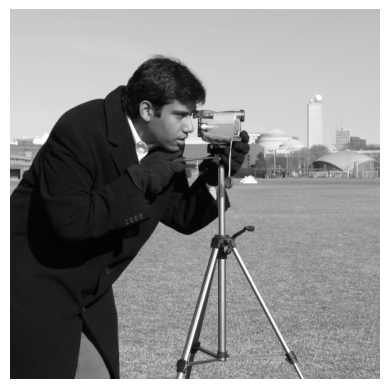

In [ ]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

Допишите код ниже и проинтерпретируйте полученный результат:

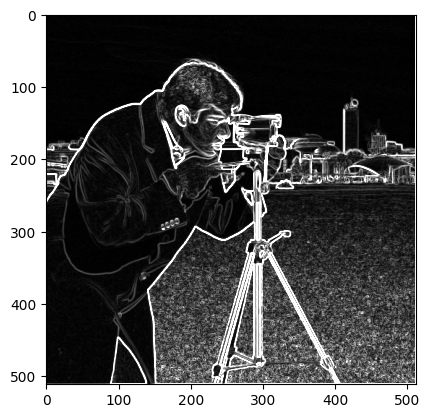

In [ ]:
camera_s_hor_filter = conv(camera, sobel_kernel_hor, stride=1, pad=1)
camera_s_vert_filter = conv(camera, sobel_kernel_vert, stride=1, pad=1)
camera_with_borders = np.sqrt(camera_s_hor_filter**2 + camera_s_vert_filter**2)
plt.imshow(camera_with_borders, cmap="gray", vmin=0, vmax=255);

Границы объектов стали выделены белым контуром.

## Задание 2. AlexNet

**15 баллов**

Воссоздайте архитектуру `AlexNet` для определения заболевания растения. Датасеты уже созданы ниже.

In [ ]:
INPUT_IMAGE_SIZE = 227
BATCH_SIZE = 64
N_EPOCHS = 10 # можно будет при желании увеличить
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from IPython.display import clear_output

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch
import os

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

clear_output()

In [ ]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

clear_output()

Archive:  train.zip
replace train/healthy/healthy_train.265.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  validation.zip
replace validation/healthy/healthy_val.6.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  test.zip
replace test/healthy/healthy_test.21.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
class BeanDataset(Dataset):
    def __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
        # папка с картинками
        self.img_dir = img_dir
        # отсортированный список с названиями файлов
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # названия папок с картинками переведем в номера классов
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # трансформации данных: мы изменяем размер,
        # так как AlexNet работает с картинками 227 на 227 пикселей
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, normalize=True):
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # применяем трансформации
        if normalize:
            transformed_img = self.transforms(image)

        transformed_img = self._transforms_for_plot(image)

        label_name = file_path.split('/')[-2]
        label = self.class_dir[label_name]

        # как обычно возвращаем картинку и номер класса
        return transformed_img, label

In [ ]:
train_dataset = BeanDataset("./train/")
valid_dataset = BeanDataset("./validation/")
test_dataset = BeanDataset("./test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Посмотрим на наши картинки:

(код довольно эзотерический, но у меня было такое настроение)

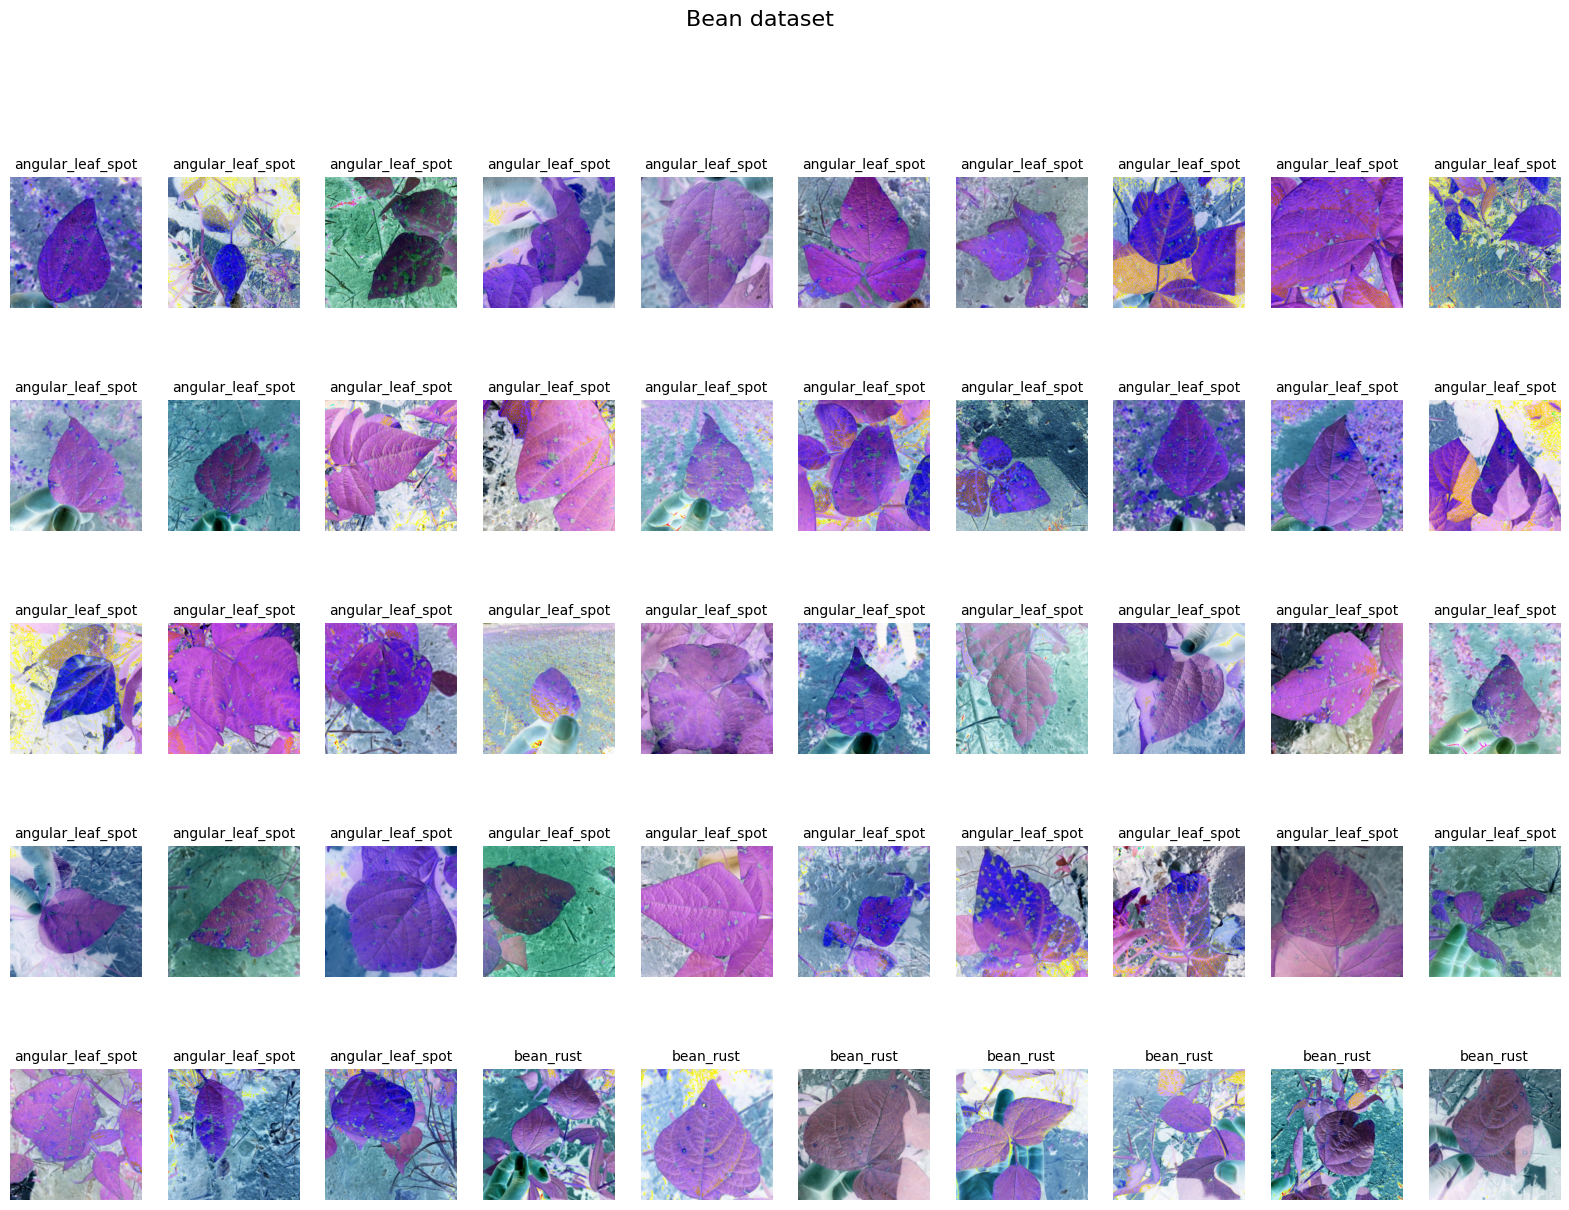

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    title = valid_dataset._number_to_labels[valid_dataset.__getitem__(index, normalize=False)[1]]
    plt.title(title, fontsize=10)

fig.suptitle("Bean dataset", fontsize=16);

### Реализация `AlexNet`

В лекции мы познакомились с архитектурой `AlexNet`, теперь пришло время реализовать ее самостоятельно. Важно, что на выходе число классов у нас будет сильно меньше чем 1000, нужно будет в начале это определить. Везде в качестве активации используется `ReLU`.

Также обратите внимание на параметры пулинга, тут ядро 3х3 со страйдом 2 (поэтому он называется overlapping).

Картинка может немного отличаться от того, что было на лекции, ориентируйтесь на картинку в ноутбуке.

Внимательно смотрите на параметры сверток (например, padding / stride).

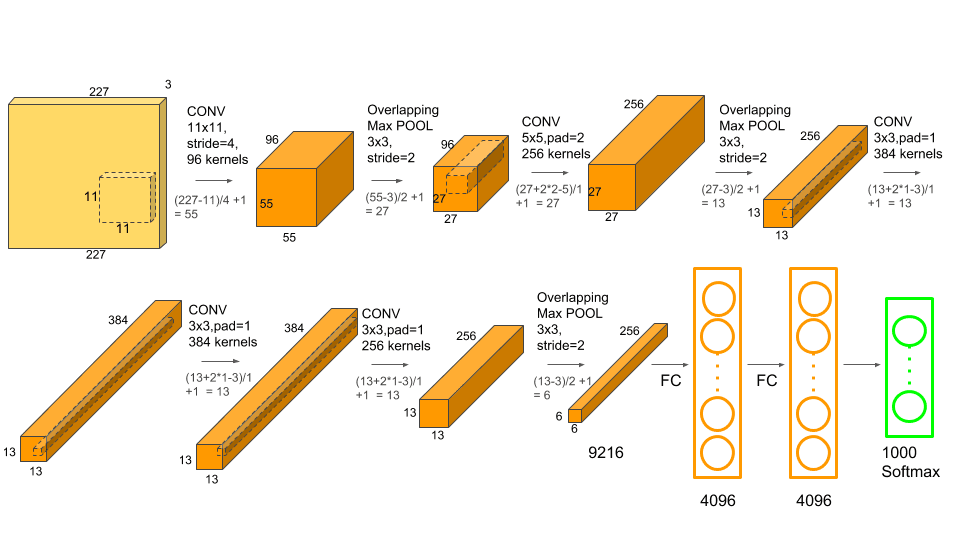

In [ ]:
N_CLASSES = 3
LEARNING_RATE = 3e-4 # можно подобрать как-то другой)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Сверточные и пулинговые слои
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # Первый слой
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Пулинг с перекрытием

            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # Второй слой
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Пулинг с перекрытием

            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # Третий слой
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # Четвертый слой
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Пятый слой
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Пулинг с перекрытием
        )
        # Полносвязанные слои
        self.classifier = nn.Sequential(
            nn.Dropout(),  # Dropout для предотвращения переобучения
            nn.Linear(256 * 6 * 6, 4096),  # Первый полносвязанный слой
            nn.ReLU(inplace=True),

            nn.Dropout(),  # Dropout перед вторым полносвязанным слоем
            nn.Linear(4096, 4096),  # Второй полносвязанный слой
            nn.ReLU(inplace=True),

            nn.Linear(4096, n_classes),  # Последний слой, зависящий от числа классов
        )

    def forward(self,x):
        # Проход через сверточные и пулинговые слои
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)  # Изменение формы для полносвязанных слоев
        # Проход через полносвязанные слои
        logits = self.classifier(x)  # Логиты
        probs = F.softmax(logits, dim=1)  # Вероятности

        return logits, probs

Возьмите код для обучения и валидации модели, который был на лекции (если захочется, то его можно как угодно менять). В лекции мы возвращали из модели помимо логитов еще и вероятности классов, чтобы потом рисовать красивые картинки. Если захотите сделать также, то учтите это.

In [ ]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model - AlexNet
    dataloader - testloader
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy


def plot_losses(train_losses, valid_losses):
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, train_losses, valid_losses

Выберите функцию потерь и оптимизатор и обучите полученную модель на тренировочных данных, параллельно проверяя ее на валидационной части:

In [ ]:
model = AlexNet(n_classes=3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

20:39:57 --- Epoch: 0	Train loss: 1.0986	Valid loss: 1.0944	Train accuracy: 35.30	Valid accuracy: 34.59
20:40:25 --- Epoch: 1	Train loss: 1.0818	Valid loss: 1.0272	Train accuracy: 58.32	Valid accuracy: 54.14
20:40:53 --- Epoch: 2	Train loss: 1.0110	Valid loss: 0.9237	Train accuracy: 56.67	Valid accuracy: 52.63
20:41:21 --- Epoch: 3	Train loss: 0.9014	Valid loss: 0.8751	Train accuracy: 65.28	Valid accuracy: 59.40
20:41:49 --- Epoch: 4	Train loss: 0.8129	Valid loss: 0.7425	Train accuracy: 70.60	Valid accuracy: 66.92
20:42:17 --- Epoch: 5	Train loss: 0.7409	Valid loss: 0.7019	Train accuracy: 70.31	Valid accuracy: 69.92
20:42:45 --- Epoch: 6	Train loss: 0.7197	Valid loss: 0.7132	Train accuracy: 74.27	Valid accuracy: 73.68
20:43:13 --- Epoch: 7	Train loss: 0.7413	Valid loss: 0.8171	Train accuracy: 69.73	Valid accuracy: 68.42
20:43:41 --- Epoch: 8	Train loss: 0.6400	Valid loss: 0.6021	Train accuracy: 76.31	Valid accuracy: 78.20
20:44:09 --- Epoch: 9	Train loss: 0.6596	Valid loss: 0.5992	Trai

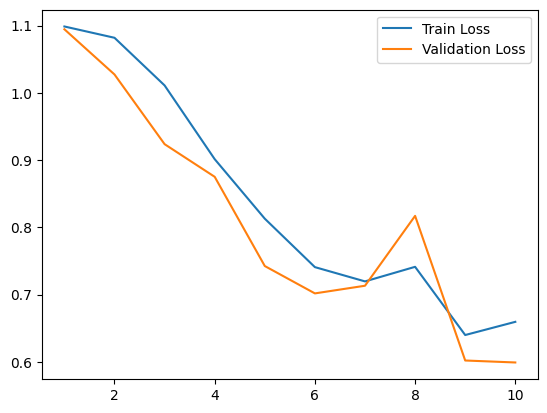

In [ ]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

Если вы все реализовали правильно, то `accuracy` на валидации должна быть в районе 0.8.

In [ ]:
get_accuracy(model, validloader, DEVICE)

0.7894736842105263

### Визуализация предсказаний

Визуализируем предсказания нашей модели и степень уверенности в них. Сделайте выводы о качестве полученной модели.

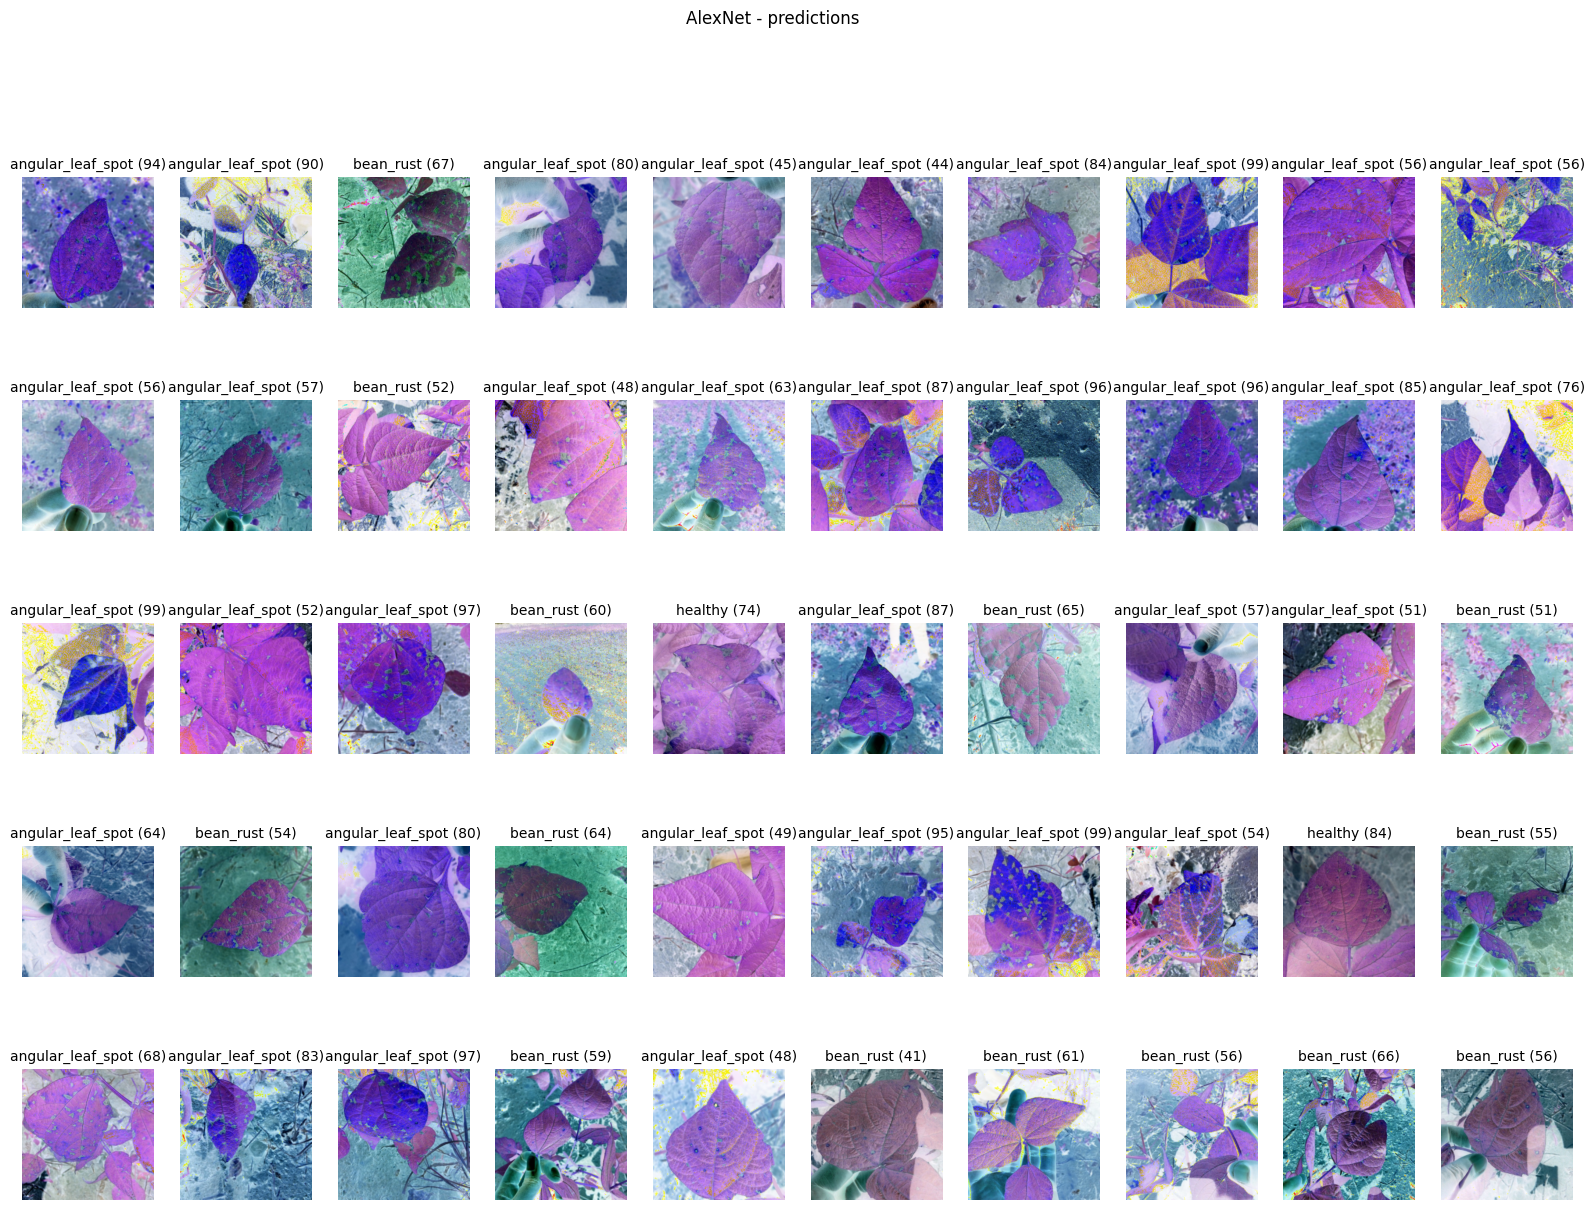

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))

    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"

    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');

Мне трудно оценить качество модели, потому что я сама плохо понимаю, какие листочки болеют angular leaf spot, а у каких листочков bean rust. Но в целом вроде про больные листики модель достаточно уверенно говорит, что они больные. Только в одном случае она написала, что листик healthy c вероятностью 74%, но на нем есть какие-то пятна и он скорее всего больной и модель ошиблась.

В целом неплохо.

## Задание 3. И снова социализация

**1 дополнительный балл**

Однажды такое уже бывало, но почему бы не повторить. Сходите погулять вместе с одногруппниками или созвонитесь в зуме, а сюда прикрепите какие-нибудь фотографии и кратко опишите, на какие темы вы общались)

Говорили про учебу и жизнь.

Тут, как обычно, можно описать свои эмоции от выполнения этого задания:

**Ответ:**